## BenMAP data analysis

1. spatial distribution of actual values
2. spatial distribution of normalized values (by race/ethinicity population by county)
3. national sum of each endpoint by race-ethinicity
4. LA state sum of each endpoint by race-ethinictiy 
5. LA state sum of each endpoint (normalized by the corresponding population ) by race-ethinictiy


#### Note that only "Emergency Room Visits  Asthma" has ethinicity separate (for White population), so I will merge them into just "White". 
## Population data is from INMAP (2013 population with race)

In [ ]:
import geopandas as gpd
import pandas as pd
import os
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as mcolors

# Function to subset data for a specific state or use national data
def subset_data(final_df, state_fips=None):
    if state_fips:
        # Ensure state_fips is a list
        if not isinstance(state_fips, list):
            state_fips = [state_fips]
        
        # Collect all states of interest, including neighbors
        all_fips = set(state_fips)

        # Filter the DataFrame
        return final_df[final_df['STATE_FIPS'].isin(all_fips)]
    return final_df

def plot_bar(df, x_column, y_column, title, output_dir, benmap_output, group_col=None):
    """
    Create an improved bar plot with better formatting and cleaner appearance.
    
    Parameters:
    -----------
    df : DataFrame
        The data to plot
    x_column : str
        Column name to use for the x-axis values
    y_column : str
        Column name to use for the y-axis values
    title : str
        Title for the plot
    output_dir : str
        Directory to save the output plot
    benmap_output: str
        type of benmap output(incidence or valuation)
    group_col : str, optional
        Column name to use for grouping/coloring. If None, no grouping is applied.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import numpy as np
    
    # Set the style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # change title
    if benmap_output == "incidence":
        plot_label = 'Health Benefits'
        if y_column == 'Mean_per_Pop':
            plot_label = plot_label + '\n (per million people) '
    elif benmap_output == 'valuation':
        if y_column == 'Mean': 
            plot_label = 'Monetized Health Benefits (in Million $)'
    
    # for valuation, make the output in million
    if benmap_output == 'valuation':
        df[y_column] = df[y_column]/1e6

    # Create the barplot with or without grouping
    if group_col:
        ax = sns.barplot(
            data=df, 
            x=x_column,
            y=y_column,
            hue=group_col,
            errorbar=None,  # Remove error bars
            palette='turbo'
        )
        add_font_size = 0 
    else:
        ax = sns.barplot(
            data=df, 
            x=x_column,
            y=y_column,
            errorbar=None,  # Remove error bars
            width=0.3,
            palette=['#3498db']  # Single color when no grouping
        )
        add_font_size= 10 # make the font size larger for none group_col case
    
    # Set title and labels with better formatting
    ax.set_title(title, fontsize=14 + add_font_size, fontweight='bold', pad=20)
    ax.set_ylabel(plot_label, fontsize=12 + add_font_size)
    ax.set_xlabel(x_column if x_column != 'Endpoint' else '', fontsize=12 + add_font_size / 2)

    # Use symlog scale for y-axis if values vary widely
    ax.set_yscale('symlog')

    # Customize legend only if group_col is provided
    if group_col:
        ax.legend(title=group_col, title_fontsize=12, fontsize=10, frameon=True)

    
    # Improve the value annotations on the bars
    for p in ax.patches:
        value = p.get_height()
        
        # Skip tiny values or exactly zero values
        if abs(value) < 0.0001:
            continue
        
        # Format numbers nicely based on their magnitude
        if abs(value) < 0.01:
            annotation = f'{value:.2f}'
        elif abs(value) < 1:
            annotation = f'{value:.1f}'
        else:
            annotation = f'{int(value)}'
        
        # Position the text better
        text_y_pos = value + (0.05 * np.sign(value))
        ax.annotate(
            annotation, 
            (p.get_x() + p.get_width() / 2., text_y_pos),
            ha='center', 
            va='bottom' if value >= 0 else 'top',
            fontsize=9 + add_font_size,
            fontweight='bold'
        )
    
    # Remove top and right spines for cleaner look
    sns.despine()
    
    # Rotate the x-tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10 + add_font_size)

    if group_col:
        # Add subtle vertical gridlines between categories
        for i in range(len(ax.get_xticks())):
            ax.axvline(x=i - 0.5, color='grey', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Add a more prominent horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
    
    # Adjust layout to make everything fit
    plt.tight_layout()
    
    # Create filename with or without group_col info
    filename = f'{title.replace(" ", "_")}'
    if group_col:
        filename += f'_by_{group_col}'
    
    # Save with higher quality
    fig.savefig(
        os.path.join(output_dir, f'{filename}.png'),
        dpi=300,
        bbox_inches='tight'
    )
    
    #plt.show()


# Creating a pretty table with plotly
def pretty_create_table(df, columns, title):
    formatted_values = [format_values(df[col]) for col in columns]
    fig = go.Figure(data=[go.Table(
        header=dict(values=columns,
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=formatted_values,
                   fill_color='lavender',
                   align='left'))
    ])
    fig.update_layout(title_text=title)
    file_path = os.path.join(output_dir, f'{TARGET_GRID_LEVEL}_{title}.png')
    fig.write_image(file_path, format='png', scale=2, engine='kaleido')
    #fig.show()

# Example function to format values
def format_values(value):
    return f'{value:.4g}' if isinstance(value, (int, float)) else value

# Function to create and save a table as CSV
def create_csv(df, columns, title, output_dir):
    # Format the values in the DataFrame
    formatted_df = df[columns].applymap(format_values)
    
    # Create the file path
    file_path = os.path.join(output_dir, f'{TARGET_GRID_LEVEL}_{title}.csv')
    
    # Save the DataFrame to CSV
    formatted_df.to_csv(file_path, index=False)
    
    print(f"CSV file saved at {file_path}")


# Function to plot spatial distribution for each race on the same page using the same color scale
def plot_spatial_distribution_combined(gdf, title, y_axis, output_dir):
    unique_races = gdf['Race'].unique()
    n_races = len(unique_races)
    fig, axes = plt.subplots(1, n_races, figsize=(5 * n_races, 8), sharex=True, sharey=True)
    fig.suptitle(title)

    vmin, vmax = gdf[y_axis].min(), gdf[y_axis].max()
    max_abs = max(abs(vmin), abs(vmax)) * 0.5

    if vmax > 0 :
        vmin = 0 
        vmax = max_abs
    else:
        vmin = -max_abs
        vmax = 0

    print(f"vmin is {vmin} and vmax is {vmax}")
    if n_races == 1:
        axes = [axes]  # Make axes iterable if there is only one subplot

    for ax, race in zip(axes, unique_races):
        race_gdf = gdf[gdf['Race'] == race]
        race_gdf.plot(column=y_axis, cmap='viridis', vmin=vmin, vmax=vmax, legend=False, ax=ax)
        ax.set_title(f'{race}')

        # Calculate the sum of the values in the domain
        if y_axis == "Mean_per_Pop":
            total_sum = race_gdf["Mean"].sum() / race_gdf["Population"].sum() * 1000000
            # Add the sum as text within the subplot
            ax.text(0.5, -0.1, f'Sum: {total_sum:.2f}', ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')
        else:  
            total_sum = race_gdf[y_axis].sum()
            # Add the sum as text within the subplot
            ax.text(0.5, -0.1, f'Sum: {total_sum:.2f}', ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')

    # Add a single color bar
    cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cbar_ax)

    plt.savefig(os.path.join(output_dir, f'{y_axis}_{TARGET_GRID_LEVEL}_{title}.png'), dpi=300, bbox_inches='tight')
    #plt.show()


# Define the preferred race order
race_order = ["ALL", "BLACK", "WHITE", "ASIAN", "NATAMER", "HISPANIC"]

def plot_spatial_distribution_benmap_with_basemap(gdf, field, output_dir, region_name):


    # Ensure the GeoDataFrame is in the correct CRS for basemaps (Web Mercator)
    gdf = gdf.to_crs(epsg=3857)

    # Group by Endpoint to ensure each endpoint is plotted separately
    grouped_endpoints = gdf.groupby("Endpoint")

    for endpoint, gdf_endpoint in grouped_endpoints:
        
        # Extract available race categories within this endpoint group
        available_races = [race for race in race_order if race in gdf_endpoint["Race"].unique()]

        # change colorbar label
        if "Mortality" in endpoint:
            colorbar_label = 'Annual Avoided number of deaths'
        elif "Asthma" in endpoint:
            colorbar_label = 'Annual Avoided number of people with the symptom'
        elif "Work" in endpoint:
            colorbar_label = 'Annual Avoided work day loss'

        if field == 'Mean_per_Pop':
            colorbar_label = colorbar_label + '\n (per million) '
    
        for race in available_races:

            # Filter data for the current race within the endpoint group
            gdf_race = gdf_endpoint[gdf_endpoint["Race"] == race]

            # Ensure the field exists
            if field not in gdf_race.columns:
                print(f'Field {field} does not exist in the data for endpoint {endpoint}, race {race}. Skipping...')
                continue

            # **Check if the field contains only zeros**
            if gdf_race[field].sum() == 0:
                print(f'All values are zero for {endpoint}, {race}. Skipping...')
                continue  # Skip this plot

            fig, ax = plt.subplots(figsize=(10, 6))

            # Plot the spatial distribution
            vmin, vmax = gdf[field].min(), gdf[field].max()
            max_abs = max(abs(vmin), abs(vmax)) * 0.5

            if vmin >= 0 :
                vmin = 0 
                vmax = max_abs

                # Define the number of discrete bins
                num_bins = 9  # Adjust this number for more or fewer steps
                color_map = plt.cm.Reds  # Choose a sequential colormap
                bounds = np.linspace(vmin, vmax, num_bins + 1)  # Define color step boundaries
                norm = mcolors.BoundaryNorm(bounds, color_map.N)  # Create a discrete colormap
                
            else:
                vmin = -max_abs
                vmax = max_abs
                # Define the number of discrete bins
                num_bins = 18  # Adjust this number for more or fewer steps
                color_map = plt.cm.get_cmap("bwr")  # Reverse coolwarm to get cool (blue) for negative and warm (red) for positive
                bounds = np.linspace(vmin, vmax, num_bins + 1)  # Define color step boundaries
                norm = mcolors.BoundaryNorm(bounds, color_map.N)  # Create a discrete colormap

            gdf_race.plot(column=field, cmap=color_map, norm = norm, vmin=vmin, vmax=vmax, 
                          legend=False, edgecolor='black', ax=ax, markersize=30, alpha=0.8)

            # Add a basemap
            ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=6)

            ax.set_title(f'{endpoint} - {race} ({region_name})')

            # Calculate summary statistics for this race
            total_target = gdf_race[field].sum()
            max_target = gdf_race[field].max()
            min_target = gdf_race[field].min()

            # Display summary stats on the plot
            ax.text(0.5, -0.15, f'Total: {total_target:.3f}\nMax: {max_target:.3f}\nMin: {min_target:.3f}', 
                    ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')


            # Add a color bar
            sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
            sm._A = []
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
            fig.colorbar(sm, cax=cbar_ax).set_label(f'{colorbar_label}')

            # Adjust layout
            plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.2)

            # Save the figure for each endpoint-race combination
            output_filename = f'{field}_{endpoint}_{race}_{region_name}_with_basemap.png'
            output_path = os.path.join(output_dir, output_filename)
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            plt.close()

            print(f'Saved: {output_path}')





In [ ]:

##############
# STEP 1: get BenMAP grid shapefile
##############

# Define file paths

TARGET_GRID_LEVEL = 'county'

if TARGET_GRID_LEVEL == 'county':

    grid_shapefile_path = '/Users/yunhalee/Documents/LOCAETA/RCM/BenMAP/grids/County/County.shp'
    grid_gdf = gpd.read_file(grid_shapefile_path)

elif TARGET_GRID_LEVEL == 'tracts':

    ## TODO - add BenMAP tract shapefile to get Row and Col information

    grid_shapefile_path = '/Users/yunhalee/Documents/LOCAETA/RCM/BenMAP/grids/US Census Tracts/US Census Tracts.shp'
    grid_gdf = gpd.read_file(grid_shapefile_path)

# Rename Columns
grid_gdf.rename( columns={"COL":"Col", "ROW": "Row"}, inplace=True)
# Define file paths

benmap_output_type =['incidence' , 'valuation'] # 
runnames = ['LA_CCS', 'LA_CCS_noNH3'] # [ 'NEI_no_Landfill_2001411', 'CO_CCS', 'CO_CCS_wo_NH3_VOC', 'CO_Cherokee_CCS_wo_NH3_VOC','CO_Suncor_CCS_wo_NH3_VOC']


for runname in runnames: 
    for benmap_output in benmap_output_type:

        benmap_output_file = f'/Users/yunhalee/Documents/LOCAETA/RCM/BenMAP/batchmode/APVR/control_{runname}_{TARGET_GRID_LEVEL}_inmap_2020_pm25-{benmap_output}.csv'
        #benmap_output_file = f"/Users/yunhalee/Documents/LOCAETA/RCM/BenMAP/batchmode/APVR/GUI_{benmap_output}_08052024.csv"
        output_dir = f"/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/BenMAP/{TARGET_GRID_LEVEL}/{benmap_output}_results/{runname}"

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)


        ##############
        # STEP 2: Create final dataframe containing geometry and BenMAP key results ,and compute the normalized Mean with the population (x1e6) for incidence
        ##############

        benmap = pd.read_csv(benmap_output_file)

        # this is only for GUI case
        benmap.rename( columns={"Column":"Col"}, inplace=True)
        benmap['Pollutant'] = 'PM2.5'
    
        # Merge incidence with pop_gdf on the 'Row' and 'Col' columns
        merged_df = benmap.merge(grid_gdf, on=['Row', 'Col'], how='left')

        if benmap_output == 'incidence':
            columns_to_keep = ['Endpoint', 'Pollutant', 'Author', 'Race', 'Ethnicity', 'STATE_FIPS','CNTY_FIPS', 'Row', 'Col', 'Mean', 'Population','geometry']
        else:
            columns_to_keep = ['Endpoint', 'Pollutant', 'Author', 'Race','Ethnicity', 'STATE_FIPS','CNTY_FIPS', 'Row', 'Col', 'Mean','geometry']

        final_df = merged_df[columns_to_keep]

        # change mortality endpoint
        # Modify Endpoint based on Author
        final_df.loc[final_df['Author'].str.contains('Pope', na=False), 'Endpoint'] = 'Mortality All Cause by Pope et al.'
        final_df.loc[final_df['Author'].str.contains('Di', na=False), 'Endpoint'] = 'Mortality All Cause by Di et al.'

        # "HISPANIC" is ethinicty, not race, but I am going to reassign it as RACE for model analysis
        final_df.loc[final_df['Ethnicity'].str.contains('HISPANIC', na=False), 'Race'] = 'HISPANIC'
        final_df.drop(columns=['Ethnicity'])

        print(f"checking race: {set(final_df['Race'])}")
        
        final_df.head()

        ##############
        # STEP 3: Create plots of total health impact (sum the health impact for each endpoint) either for State or Nation and Create map plots of local health impact
        ##############

        # Dictionary to loop over
        #regions = {"CO": '08', "Nation": None}
        regions = {"LA": ['22','05', "28", "48"] , "Nation": None}

        final_df = gpd.GeoDataFrame(final_df, geometry= "geometry")
        type(final_df)

        # Loop over the regions dictionary and process the data
        for region_name, state_fips in regions.items():
            
            # Subset the final DataFrame based on the chosen state or national
            final_df_subset = subset_data(final_df, state_fips)

            print(f"Processing data for: {region_name}")
            #print(final_df_subset.head())

            if benmap_output == 'incidence':
                # Group by ['Endpoint', 'Pollutant', 'Author', 'Race'] and calculate the sum of 'Mean'
                race_grouped_sum = final_df_subset.groupby(['Endpoint', 'Pollutant', 'Author', 'Race']).agg({'Mean': 'sum', "Population":"sum"}).reset_index()

                race_grouped_sum['Mean_per_Pop'] = race_grouped_sum['Mean'] / race_grouped_sum['Population'] * 1000000  # Scale by 1,000,000 for readability

                #print("race_grouped_sum", race_grouped_sum.head())

                # Plotting "SUM" barplots by 'Race' for each {endpoint}, {pollutant}, {author}
                plot_bar(race_grouped_sum, "Endpoint", "Mean", f'Health benefits by Race in {region_name}', output_dir, benmap_output, 'Race')
                
                plot_bar(race_grouped_sum, "Endpoint", "Mean_per_Pop", f'Normalized Health benefits by Race in {region_name}', output_dir, benmap_output,'Race')

                # Creating a table to show the values in the barplots
                table_columns = ['Endpoint', 'Race', 'Mean', 'Mean_per_Pop']

            else:
                # Group by ['Endpoint', 'Pollutant', 'Author', 'Race'] and calculate the sum of 'Mean'
                race_grouped_sum = final_df_subset.groupby(['Endpoint', 'Pollutant', 'Author', 'Race']).agg({'Mean': 'sum'}).reset_index()

                # Plotting "SUM" barplots by 'Race' for each {endpoint}, {pollutant}, {author}
                plot_bar(race_grouped_sum, "Endpoint", "Mean", f'Monetized Health benefits by Race in {region_name}', output_dir, benmap_output, 'Race')

                # Creating a table to show the values in the barplots
                table_columns = ['Endpoint', 'Race', 'Mean']

            print("create csv started")
            create_csv(race_grouped_sum, table_columns, f'Summary Table Health Benefits by Race in {region_name}', output_dir)

            #result = final_df_subset[final_df_subset['Race'] == 'ALL'].groupby('Endpoint')['Mean'].sum().reset_index()
            #plot_bar(result, "Endpoint", "Mean", f'Sum of Mean by Endpoint in {region_name}', output_dir)

            # Group by ['Endpoint', 'Pollutant', 'Author']
            grouped = final_df_subset.groupby(['Endpoint', 'Pollutant', 'Author'])

            for (endpoint, pollutant, author), group in grouped:

                #if region_name != 'Nation': # skip Nation mapping 
                    ## print(f"checking group df {group.head()}")
                    
                print("basemap mapping started")
                ## title_mean = f'Spatial Distribution for {endpoint} ({pollutant}, {author}) in {region_name}'
                ## plot_spatial_distribution_combined(group, title_mean, "Mean", output_dir)
                plot_spatial_distribution_benmap_with_basemap(group, "Mean", output_dir, region_name)
            
                if benmap_output == 'incidence':
                    group['Mean_per_Pop'] = group.apply(lambda row: row['Mean'] / row['Population'] * 1000000, axis=1)  # Scale by 1,000,000 for readability

                    print("normalized basemap mapping started")
                    plot_spatial_distribution_benmap_with_basemap(group, "Mean_per_Pop", output_dir, region_name)
                    ## title_mean_per_pop = f'Spatial Distribution for {endpoint} ({pollutant}, {author}) per Population in {region_name}'
                    ## plot_spatial_distribution_combined(group, title_mean_per_pop, "Mean_per_Pop", output_dir)

## Make health impact bar plot for all runs

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_health_benefit(combined_df, y_label, output_dir): 
    # Convert DataFrame from wide to long format
    df_long = combined_df.melt(id_vars=["Endpoint", "Race"], var_name="Run", value_name="Value")

    # Remove rows with NaN values
    df_long = df_long.dropna(subset=["Value"])

    # Skip zero values if desired
    df_long = df_long[df_long["Value"] != 0]

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Determine the number of unique "Endpoint" categories with data
    endpoints_with_data = df_long["Endpoint"].unique()
    num_endpoints = len(endpoints_with_data)

    # Adjust figure size dynamically
    fig_width = min(25, num_endpoints * 8)
    fig_height = 10

    # Create figure and axes manually for better control
    fig = plt.figure(figsize=(fig_width, fig_height))

    # Create a grid of subplots
    if num_endpoints <= 3:
        ncols = num_endpoints
    else:
        ncols = 3
        
    nrows = (num_endpoints + ncols - 1) // ncols
    gridspec = fig.add_gridspec(nrows=nrows, ncols=ncols, hspace=0.4, wspace=0.3)

    # Create each subplot individually
    for i, endpoint in enumerate(endpoints_with_data):
        row, col = i // ncols, i % ncols
        ax = fig.add_subplot(gridspec[row, col])
        
        # Filter data for this endpoint
        endpoint_data = df_long[df_long["Endpoint"] == endpoint]
        
        # Skip if no data
        if len(endpoint_data) == 0:
            continue
            
        # Create the bar plot
        ax = sns.barplot(data=endpoint_data, x="Race", y="Value", hue="Run", ax=ax)

        # Set title and labels
        ax.set_title(f"Endpoint: {endpoint}", fontsize=13, fontweight="bold")
        ax.set_xlabel("Race-Ethnicity", fontsize=15)
        ax.set_ylabel(y_label, fontsize=15)

        # Regular rotation for other endpoints
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
        
        # Remove legend from individual subplots (we'll add a common one later)
        ax.get_legend().remove()

        # Add vertical gridlines between categories
        # Get the actual x tick positions
        tick_positions = ax.get_xticks()
        for j in range(len(tick_positions)):
            if j > 0:  # Skip the first one to avoid a line at the left edge
                # Place gridline between tick positions
                midpoint = (tick_positions[j-1] + tick_positions[j]) / 2
                ax.axvline(x=midpoint, color='grey', linestyle='--', linewidth=0.5, alpha=0.6)
        
        # Remove legend from individual subplots (we'll add a common one later)
        if hasattr(ax, 'get_legend') and ax.get_legend() is not None:
            ax.get_legend().remove()

    # Add a single legend for the entire figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title="Run", loc="upper center", 
            bbox_to_anchor=(0.5, 0.05), ncol=min(5, len(labels)), frameon=True)

    # Improve overall layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for the legend

    plt.show()



Combined DataFrame for incidence:
                                     Endpoint      Race     LA_CCS  \
0                 Asthma Exacerbation  Cough       ALL   862.7000   
1                 Asthma Exacerbation  Cough     BLACK   161.9000   
2   Asthma Exacerbation  Shortness of Breath       ALL  1244.0000   
3   Asthma Exacerbation  Shortness of Breath     BLACK   233.4000   
4                Asthma Exacerbation  Wheeze       ALL  1970.0000   
5                Asthma Exacerbation  Wheeze     BLACK   369.6000   
6           Mortality All Cause by Di et al.       ALL    37.7000   
7           Mortality All Cause by Di et al.     ASIAN     0.8213   
8           Mortality All Cause by Di et al.     BLACK    10.9400   
9           Mortality All Cause by Di et al.  HISPANIC     4.9680   
10          Mortality All Cause by Di et al.   NATAMER     0.3271   
11          Mortality All Cause by Di et al.     WHITE    33.1600   
12        Mortality All Cause by Pope et al.       ALL    76.4100   

/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

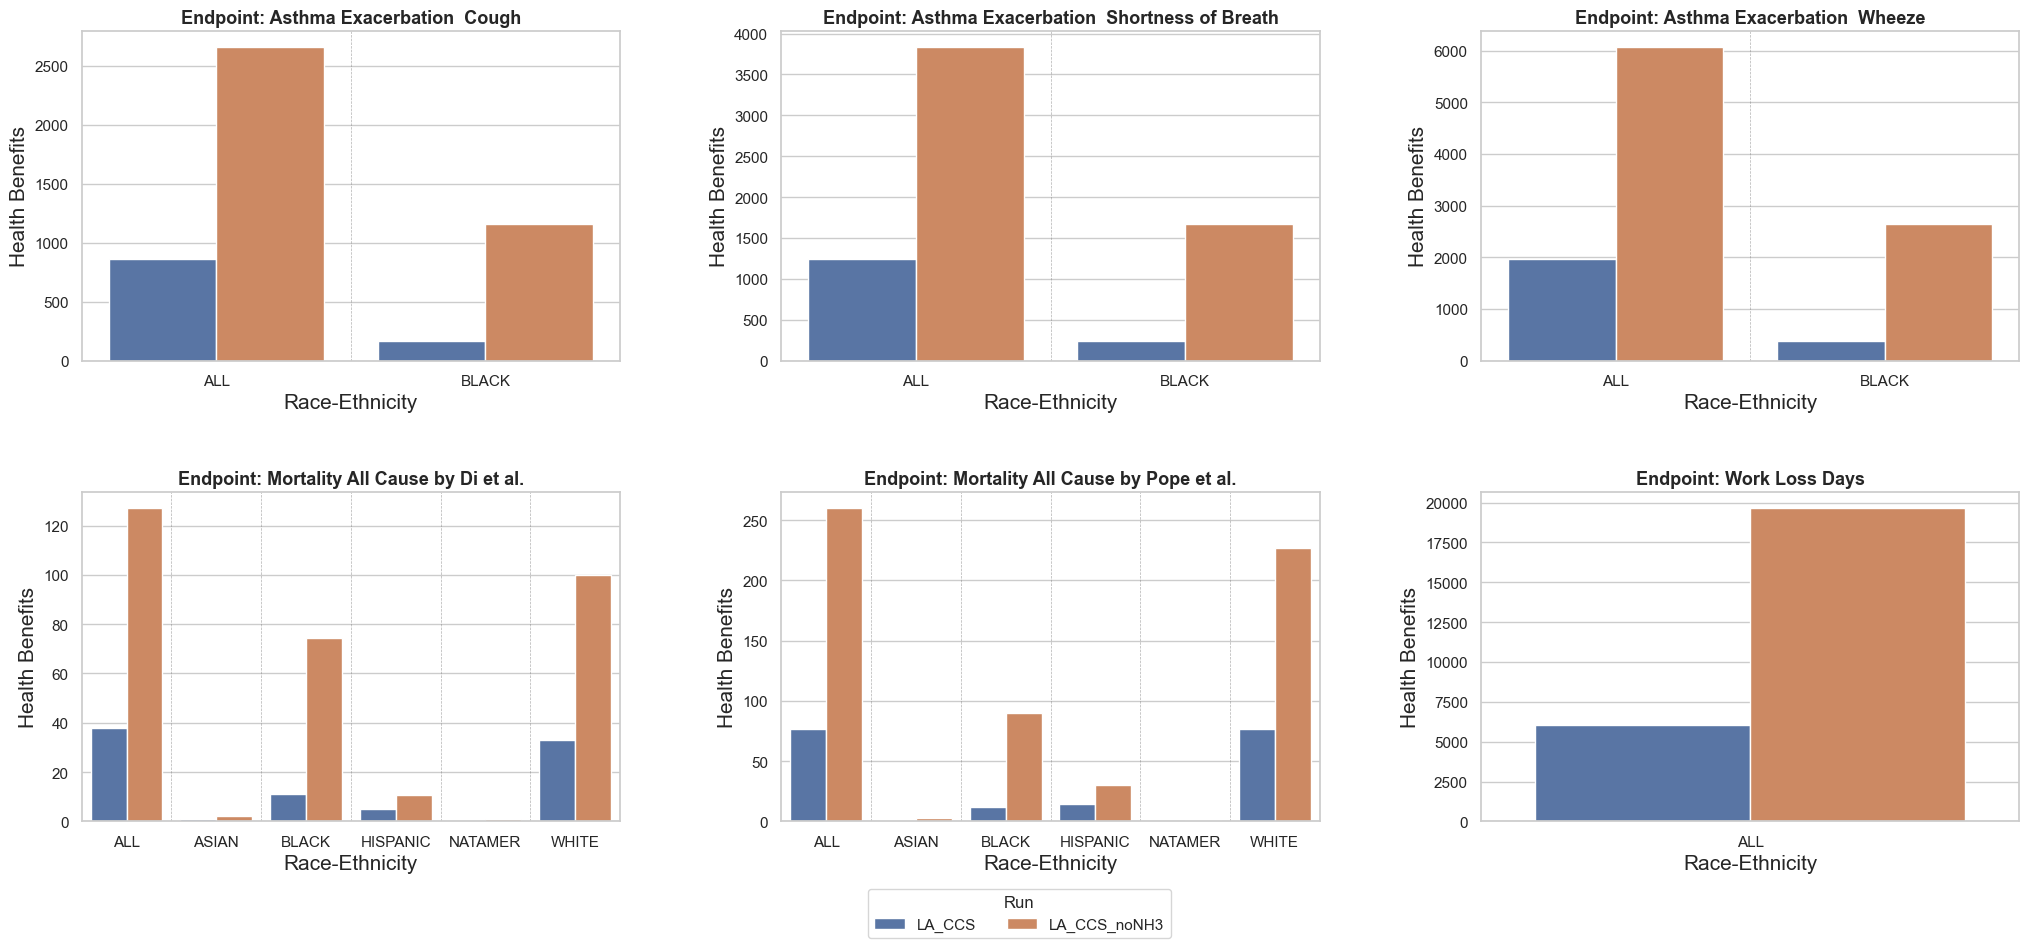

/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

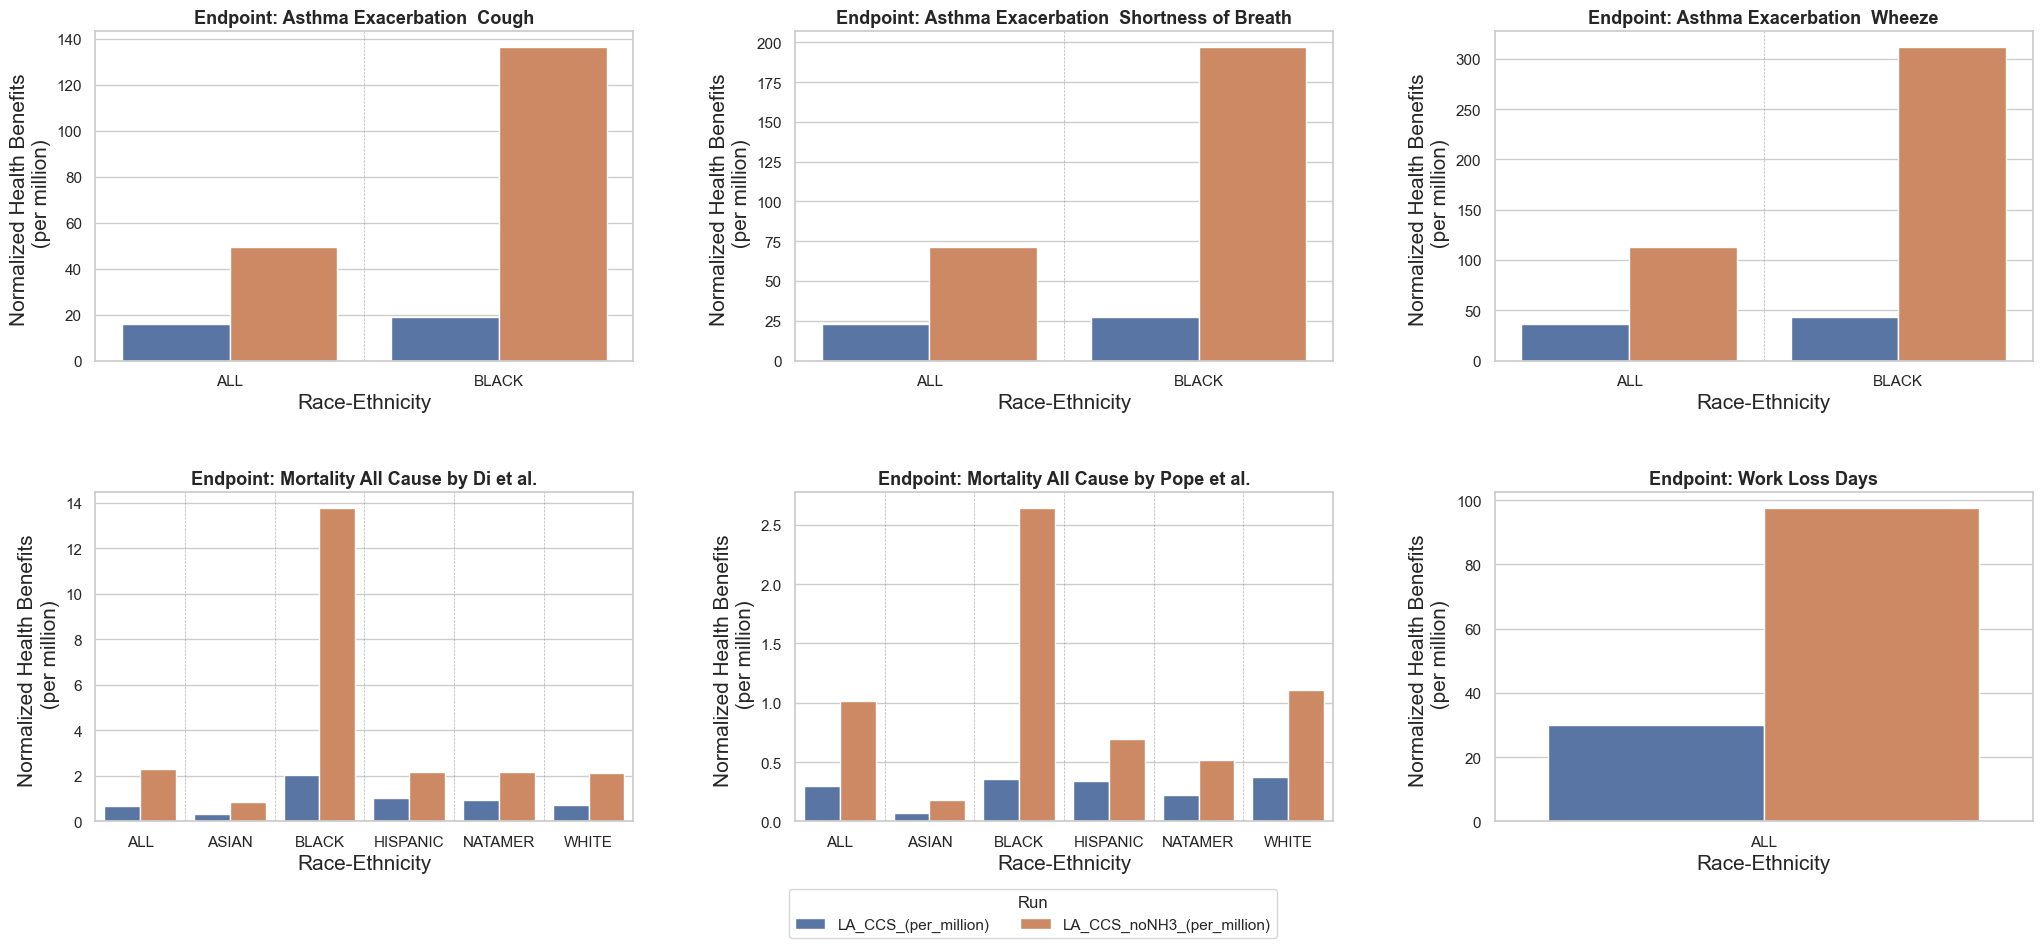

Combined DataFrame for valuation:
                                     Endpoint      Race     LA_CCS  \
0                 Asthma Exacerbation, Cough       ALL    0.20240   
1                 Asthma Exacerbation, Cough     BLACK    0.03798   
2   Asthma Exacerbation, Shortness of Breath       ALL    0.29200   
3   Asthma Exacerbation, Shortness of Breath     BLACK    0.05477   
4                Asthma Exacerbation, Wheeze       ALL    0.46230   
5                Asthma Exacerbation, Wheeze     BLACK    0.08672   
6           Mortality All Cause by Di et al.       ALL  322.90000   
7           Mortality All Cause by Di et al.     ASIAN    7.03200   
8           Mortality All Cause by Di et al.     BLACK   93.68000   
9           Mortality All Cause by Di et al.  HISPANIC   42.53000   
10          Mortality All Cause by Di et al.   NATAMER    2.79900   
11          Mortality All Cause by Di et al.     WHITE  284.00000   
12        Mortality All Cause by Pope et al.       ALL  654.10000   

/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_56452/1827233824.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

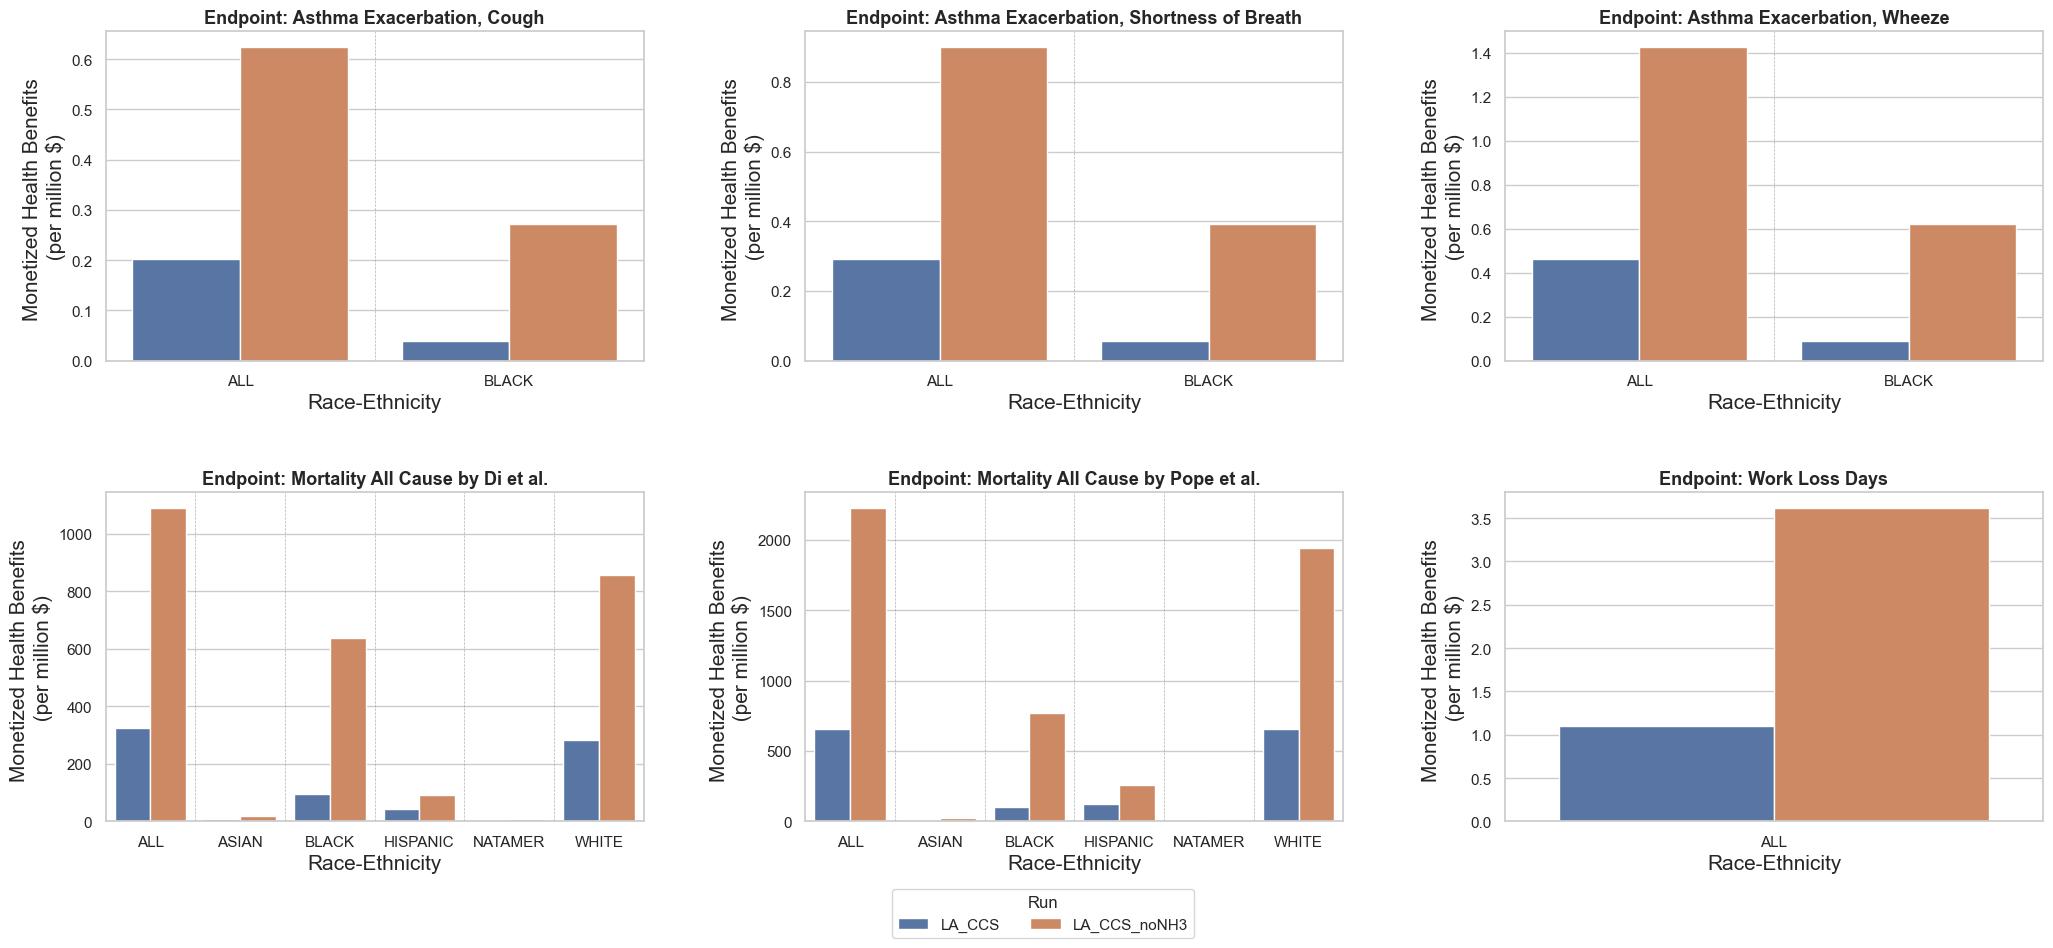

In [6]:
import pandas as pd

# Define file paths
benmap_output_type =['incidence' , 'valuation']
TARGET_GRID_LEVEL = 'county'
runnames = ['LA_CCS', 'LA_CCS_noNH3'] # ['CO_CCS', 'CO_CCS_wo_NH3_VOC', 'CO_Cherokee_CCS_wo_NH3_VOC','CO_Suncor_CCS_wo_NH3_VOC' ,  'NEI_no_Landfill_2001411']
target_file = 'County_Summary Table Health Benefits by Race in Nation.csv'


for benmap_output in benmap_output_type:
    combined_df = None
    combined_df_normalized = None

    # Iterate over each run name
    for runname in runnames:
        # Construct the file path
        output_dir = f"/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/BenMAP/{TARGET_GRID_LEVEL}/{benmap_output}_results/"
        
        # Read the CSV file
        df = pd.read_csv(output_dir + runname + "/" + target_file)
        
        # Filter out rows where 'Mean' is zero
        df = df[df['Mean'] != 0]
        
        if benmap_output == 'incidence' :
            # Rename columns to include the run name
            df.rename(columns={'Mean': runname, 'Mean_per_Pop': f'{runname}_(per_million)'}, inplace=True)
        else:
            df.rename(columns={'Mean': runname}, inplace=True)
        
        # Select only the necessary columns for merging
        df_mean = df[['Endpoint', 'Race', runname]]

        # Merge DataFrames on 'Endpoint' and 'Race'
        if combined_df is None:
            combined_df = df_mean  # Initialize with the first DataFrame
        else:
            combined_df = pd.merge(combined_df, df_mean, on=['Endpoint', 'Race'], how='outer')

        if benmap_output == 'incidence' :
            df_normalized = df[['Endpoint', 'Race', f'{runname}_(per_million)']]
        
            if combined_df_normalized is None:
                combined_df_normalized = df_normalized  # Initialize with the first DataFrame
            else:
                combined_df_normalized = pd.merge(combined_df_normalized, df_normalized, on=['Endpoint', 'Race'], how='outer')

    # Print or process the combined DataFrames
    print(f"Combined DataFrame for {benmap_output}:\n", combined_df)
    print(f"Combined Normalized DataFrame for {benmap_output}:\n", combined_df_normalized)

    if benmap_output == 'incidence' :
        plot_health_benefit(combined_df, 'Health Benefits', output_dir)
        plot_health_benefit(combined_df_normalized, "Normalized Health Benefits \n (per million)", output_dir)

        combined_df.to_csv(output_dir + "Health_Benefit_all_CO_runs.csv")
        combined_df_normalized.to_csv(output_dir + "Normalized_Health_Benefit_all_CO_runs.csv")

    elif benmap_output == 'valuation':
        plot_health_benefit(combined_df, 'Monetized Health Benefits \n (per million $) ', output_dir)
        combined_df.to_csv(output_dir + "Monetized_Health_Benefit_all_CO_runs.csv")


In [ ]:
import pandas as pd
import os

main_dir = '/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/model_analysis/'
run_list = ['LA_CCS', 'LA_CCS_noNH3'] # ['CO_CCS', 'CO_CCS_wo_NH3_VOC', 'CO_Suncor_wo_NH3_VOC','CO_Cherokee_wo_NH3_VOC', 'NEI_no_Landfill_2001411']
target_file = 'area_weighted_averages.csv'

combined_df = None

for run in run_list:
    output_path = os.path.join(main_dir, run)
    df = pd.read_csv(output_path + '/'+target_file)

    df.rename(columns={"Area-Weighted Average": run}, inplace=True)

    # Merge on 'Species' column
    if combined_df is None:
        combined_df = df  # First dataframe, set as base
    else:
        combined_df = pd.merge(combined_df, df, on="Species", how="outer")

# Print and check final DataFrame
print(combined_df)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pandas.api.types import CategoricalDtype

# Define your desired order of species
species_order = ["NH3", "SOA", "NOx","SOx","PNH4", "PNO3", "PSO4", "PrimPM25", "TotalPM25"]  # Modify as needed

# Convert DataFrame from wide to long format
df_long = combined_df.melt(id_vars=["Species"], var_name="Run", value_name="Area-Weighted Average")

# Convert "Species" to a categorical type with the defined order
species_cat = CategoricalDtype(categories=species_order, ordered=True)
df_long["Species"] = df_long["Species"].astype(species_cat)

# Sort the DataFrame to ensure correct plotting order
df_long = df_long.sort_values("Species")


# Set Seaborn style
sns.set_style("whitegrid")

# Create figure and bar plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df_long, x="Species", y="Area-Weighted Average", hue="Run", palette="tab10")

# Customize the plot
plt.title("Area-Weighted Averages by Species Across Runs", fontsize=25, fontweight="bold", pad=20)
plt.xlabel("Species", fontsize=20)
plt.ylabel("Area-Weighted Average [ug/m³]", fontsize=18)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title="Run", title_fontsize=14, fontsize=16, frameon=True)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Add subtle vertical gridlines between categories
for i in range(len(ax.get_xticks())):
    ax.axvline(x=i - 0.5, color='grey', linestyle='--', linewidth=0.5, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

The following code isn't what I need but I want to keep it for future use


# Use a mapping from 'Race' to the appropriate population column
race_to_pop_col = {
    'WHITE': 'White',
    'BLACK': 'Black',
    'NATAMER': 'Native',
    'ASIAN': 'Asian',
    'ALL': 'TotalPop'
}

# Apply the division and save population value
def calculate_ratio(row):
    pop_col = race_to_pop_col.get(row['Race'])
    if pop_col and row[pop_col] != 0:
        return row[pop_col], row['Mean'] / row[pop_col] *1000000  # The value is increased by 1e6 (because it is too small)
    else:
        return None, None

# Apply the function to calculate ratio and populate 'Race_population'
merged_df[['Race_population', 'Mean_per_Pop']] = merged_df.apply(lambda row: pd.Series(calculate_ratio(row)), axis=1)
